# Calibrate GAM and NGAM

In [14]:
import pandas as pd
from reframed import FBA, Environment, load_cbmodel, save_cbmodel
from scipy.stats import linregress
import matplotlib.pyplot as plt

In [2]:
model = load_cbmodel('../models/RcH10_v2.xml')

In [3]:
media = pd.read_csv('../input/media_db.tsv',sep='\t')
media_cellb = media[media.medium=='DM_cellobiose']
env_cellb = Environment.from_compounds(list(media_cellb['compound']))
env_cellb.apply(model, inplace=True, exclusive=True, warning=False)

In [4]:
chemostat= pd.read_excel('../input/Guedon1999_chemostat_data.xlsx', sheet_name='Sheet1', header=None, index_col=0, usecols="A:H")
mu = chemostat.iloc[0,:].values
q_cellb = chemostat.iloc[1,:].values

In [5]:
#Setting GAM values in biomass function
model.reactions.Growth.stoichiometry['M_atp_c']=0
model.reactions.Growth.stoichiometry['M_adp_c']=0
model.reactions.Growth.stoichiometry['M_h_c']=0
model.reactions.Growth.stoichiometry['M_pi_c']=0

#### <span style="color: blue;">Linear regression</span>

In [6]:
max_atp=[]

for q_i in q_cellb:
    sol = FBA(model, constraints={'R_EX_cellb_e': (-q_i, 0)}, objective={'R_ATPM': 1})
    max_atp.append(sol.fobj)

In [7]:
GAM, NGAM, r, p, se = linregress(mu, max_atp)
GAM, NGAM = round(GAM, 1), round(NGAM, 1)

In [8]:
print(f'GAM:{GAM} NGAM: {NGAM}')

GAM:59.3 NGAM: 3.4


In [9]:
#Setting GAM values in biomass function
model.reactions.Growth.stoichiometry['M_atp_c']=-GAM
model.reactions.Growth.stoichiometry['M_adp_c']=GAM
model.reactions.Growth.stoichiometry['M_h_c']=GAM
model.reactions.Growth.stoichiometry['M_pi_c']=GAM

In [10]:
#Setting NGAM values in the ATPM function
model.reactions.R_ATPM.lb=NGAM

In [11]:
## pFBA prediction of growth rate and product production
mu_sim = []

for q_i in q_cellb:
    sol = FBA(model, constraints={'R_EX_cellb_e': (-q_i, 0)})
    mu_i = sol.fobj if sol.fobj is not None else 0
    mu_sim.append(mu_i)

# NOTE: this is still not working, needs to be fixed !!

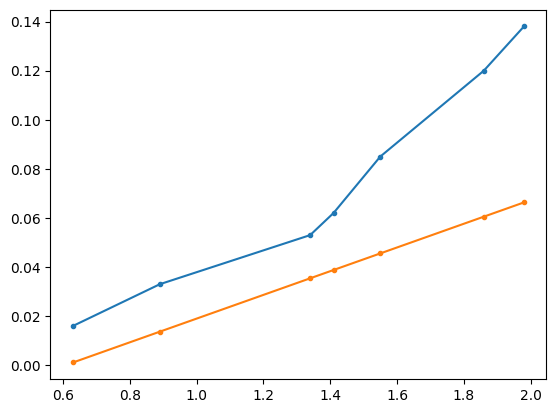

In [12]:
plt.plot(q_cellb, mu, '.-')
plt.plot(q_cellb, mu_sim, '.-')

In [15]:
save_cbmodel(model, '../models/RcH10_final.xml')